In [7]:
import numpy as np
import sncosmo
from astropy.table import Table
from matplotlib import pyplot as plt

import sys; sys.path.insert(0, '../')
from data_access import sdss_data


## Get SDSS published table of spectroscopically confirmed SNIa

In [2]:
spec_confirmed_sn = sdss_data.master_table[sdss_data.master_table['Classification'] == 'zSNIa']
spec_confirmed_sn.show_in_notebook(display_length=10)

idx,CID,RA,DEC,Nsearchepoch,IAUName,Classification,Peakrmag,MJDatPeakrmag,NepochSNR5,nSNspec,nGALspec,zspecHelio,zspecerrHelio,zCMB,zerrCMB,x0SALT2zspec,x0errSALT2zspec,x1SALT2zspec,x1errSALT2zspec,cSALT2zspec,cerrSALT2zspec,PeakMJDSALT2zspec,PeakMJDderrSALT2zspec,muSALT2zspec,muerrSALT2zspec,fitprobSALT2zspec,chi2SALT2zspec,ndofSALT2zspec,deltaMLCS2k2zspec,deltaerrMLCS2k2zspec,avMLCS2k2zspec,averrMLCS2k2zspec,PeakMJDMLCS2k2zspec,PeakMJDerrMLCS2k2zspec,muMLCS2k2zspec,muerrMLCS2k2zspec,fitprobMLCS2k2zspec,chi2MLCS2k2zspec,ndofMLCS2k2zspec,PIaPSNIDzspec,logprobIaPSNIDzspec,lcqualityIaPSNIDzspec,PIbcPSNIDzspec,logprobIbcPSNIDzspec,lcqualityIbcPSNIDzspec,PIIPSNIDzspec,logprobIIPSNIDzspec,lcqualityIIPSNIDzspec,NnnPSNIDzspec,PnnIaPSNIDzspec,PnnIbcPSNIDzspec,PnnIIPSNIDzspec,zPSNIDzspec,zerrPSNIDzspec,dm15PSNIDzspec,dm15errPSNIDzspec,avPSNIDzspec,averrPSNIDzspec,PeakMJDPSNIDzspec,PeakMJDerrPSNIDzspec,SNIbctypePSNIDzspec,SNIItypePSNIDzspec,x0SALT2flat,x0errSALT2flat,x1SALT2flat,x1errSALT2flat,cSALT2flat,cerrSALT2flat,PeakMJDSALT2flat,PeakMJDerrSALT2flat,zphotSALT2flat,zphoterrSALT2flat,fitprobSALT2flat,chi2SALT2flat,ndofSALT2flat,PIaPSNIDflat,logprobIaPSNIDflat,lcqualityIaPSNIDflat,PIbcPSNIDflat,logprobIbcPSNIDflat,lcqualityIbcPSNIDflat,PIIPSNIDflat,logprobIIPSNIDflat,lcqualityIIPSNIDflat,NnnPSNIDflat,PnnIaPSNIDflat,PnnIbcPSNIDflat,PnnIIPSNIDflat,zPSNIDflat,zerrPSNIDflat,dm15PSNIDflat,dm15errPSNIDflat,avPSNIDflat,averrPSNIDflat,PeakMJDPSNIDflat,PeakMJDerrPSNIDflat,SNIbctypePSNIDflat,SNIItypePSNIDflat,objIDHost,RAhost,DEChost,separationhost,DLRhost,zphothost,zphoterrhost,zphotRFhost,zphotRFerrhost,dereduhost,erruhost,deredghost,errghost,deredrhost,errrhost,deredihost,errihost,deredzhost,errzhost,logMassFSPS,logMassloFSPS,logMasshiFSPS,logSSFRFSPS,logSSFRloFSPS,logSSFRhiFSPS,ageFSPS,ageloFSPS,agehiFSPS,minredchi2FSPS,logMassPEGASE,logMassloPEGASE,logMasshiPEGASE,logSFRPEGASE,logSFRloPEGASE,logSFRhiPEGASE,agePEGASE,minchi2PEGASE,Notes
0,703,336.217897,0.650723,5,--,zSNIa,21.3,53623.2,6,0,1,0.298042,2e-05,0.296481,2e-05,5.43e-05,3.47e-06,0.73,0.63,-0.01,0.05,53626.5,0.65,40.8,0.24,0.966,40.8,59,-0.27,0.13,0.34,0.14,53625.5,0.78,40.86,0.17,0.998,44.4,74,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,5.29e-05,3.8e-06,0.77,0.69,-0.05,0.08,53626.6,0.81,0.3177,0.0418,0.953,27.9,42,1.0,0.0,63,0.0,-0.0061,63,0.0,-0.161,63,1278,0.985,0.009,0.005,0.313,0.0308,0.92,0.11,0.02,0.21,53625.48,0.89,306,301,1237663544222483004,336.217957,0.650779,0.21,0.25,0.392,0.0682,0.3174,0.0959,22.305,0.313,21.829,0.093,20.89,0.064,20.622,0.078,20.453,0.217,9.96,9.83,10.08,-10.17,-10.37,-10.0,3.74,2.39,5.58,0.16,9.86,9.57,10.16,0.41,-0.14,0.61,1.8,0.68,--
1,735,7.963306,0.801202,5,--,zSNIa,21.0,53616.3,4,0,0,0.190858,4.5e-05,0.189482,4.5e-05,8.82e-05,1.23e-05,-2.66,0.58,0.01,0.09,53610.7,1.79,39.61,0.27,0.955,20.6,33,1.4,0.13,-0.66,0.19,53615.1,1.19,39.9,0.17,0.917,46.4,61,1.0,-0.0039,51,0.0,-0.369,59,0.0,-8.88,3,--,--,--,--,0.2403,0.0829,1.53,0.15,-0.04,0.6,53610.85,2.18,4,4,--,--,--,--,--,--,--,--,--,--,--,--,--,0.961,-0.0,55,0.039,-0.0074,63,0.0,-3.56,55,151,0.927,0.04,0.033,0.2697,0.0721,1.55,0.14,-0.07,0.48,53612.43,2.49,307,301,1237663204917641393,7.963525,0.80104,1.01,0.98,0.1989,0.0099,0.2081,0.0351,22.605,0.469,20.398,0.033,19.082,0.016,18.579,0.017,18.198,0.037,10.83,10.73,10.92,-15.92,-44.04,-12.45,8.35,5.46,10.35,0.09,10.68,10.62,10.72,-99.0,-99.0,-99.0,8.0,1.77,--
2,779,26.673767,-1.020637,7,--,zSNIa,20.8,53626.4,8,0,1,0.238121,2.1e-05,0.236938,2.1e-05,7.72e-05,3.68e-06,0.46,0.38,0.02,0.04,53626.9,0.41,40.3,0.21,0.991,42.8,67,-0.19,0.11,0.36,0.11,53626.0,0.63,40.39,0.13,0.99,55.2,82,1.0,0.0,63,0.0,-1.65,63,0.0,-13.0,63,--,--,--,--,0.2424,0.0286,0.96,0.08,0.31,0.22,53626.05,0.68,3,1,7.6e-05,3.74e-06,0.52,0.4,0.02,0.06,53627.1,0.53,0.2472,0.0289,0.92,35.8,49,1.0,0.0,63,0.0,-1.43,63,0.0,-1.91,63,1766,0.981,0.003,0.016,0.25,0.0288,0.95,0.08,0.34,0.21,53626.14,0.71,306,301,1237657069548208337,26.673767,-1.020636,0.23,0.2,0.2132,0.0403,0.

## Pick an arbitrary target and look at the light curve

Published Values for CID 822:
('x0: ', 6.82e-05)
('x1: ', -0.38)
('c: ', -0.09)
('chisq: ', 53.5)
('ndof: ', 53)
('chisq_norm: ', 1.009433962264151)


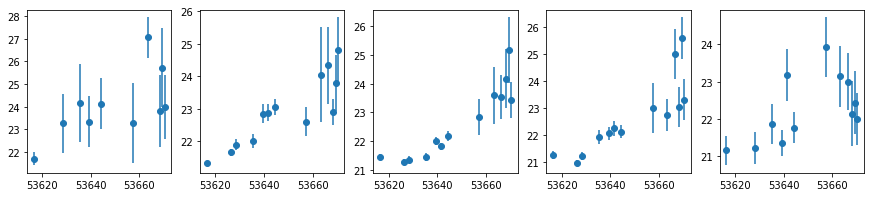

idx,FLAG,MJD,FILT,MAG,MERR,MSKYERR,MGALERR,FLUX,FLUXERR,SKYERR,GALERR,NPRE,TELE,RUN,STRIP,IDCCD
0,0,53616.425104,1,21.325,0.067,0.021,0.06,10.51,0.6382,0.1981,0.5731,16,sdss,5566,82N,1
1,0,53616.421787,2,21.436,0.102,0.045,0.073,9.608,0.9047,0.4044,0.6455,22,sdss,5566,82N,1
2,0,53616.422616,3,21.259,0.149,0.143,0.088,11.16,1.532,1.478,0.9121,24,sdss,5566,82N,1
3,0,53616.424275,4,21.149,0.401,0.309,0.323,11.93,4.675,3.71,3.881,24,sdss,5566,82N,1
4,136,53616.423445,0,21.698,0.298,0.351,0.739,8.058,2.049,2.471,5.2,11,sdss,5566,82N,1
5,128,53626.402442,1,21.668,0.108,0.025,0.131,7.657,0.7474,0.1723,0.9114,16,sdss,5603,82N,1
6,2,53626.399124,2,21.259,0.113,0.141,0.153,11.32,1.182,1.478,1.602,22,sdss,5603,82N,1
7,8,53626.399954,3,20.968,0.106,0.221,0.067,14.62,1.431,2.985,0.9129,24,sdss,5603,82N,1
8,1,53628.387558,1,21.896,0.178,0.096,0.093,6.2,0.9958,0.5438,0.5237,16,sdss,5610,82N,1
9,0,53628.384241,2,21.345,0.114,0.036,0.052,10.45,1.101,0.3479,0.5051,22,sdss,5610,82N,1


In [8]:
test_id = 822

# Get fit published values
published_values = sdss_data.master_table[sdss_data.master_table['CID'] == test_id]
x0 = published_values['x0SALT2zspec'][0]
x1 = published_values['x1SALT2zspec'][0]
c = published_values['cSALT2zspec'][0]
chisq_norm = published_values['chi2SALT2zspec'][0] / published_values['ndofSALT2zspec'][0]
peak_mjd = published_values['MJDatPeakrmag'][0]

print('Published Values for CID {}:'.format(test_id))
print('x0: ', x0)
print('x1: ', x1)
print('c: ', c)
print('chisq: ', published_values['chi2SALT2zspec'][0])
print('ndof: ', published_values['ndofSALT2zspec'][0])
print('chisq_norm: ', chisq_norm)

# Get sdss photometry data
phot_data = sdss_data.get_data_for_id(test_id)
phot_data = phot_data[phot_data['FLAG'] < 1024]
phot_data = phot_data[phot_data['MJD'] < peak_mjd + 45]
phot_data = phot_data[phot_data['MJD'] > peak_mjd - 15]

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    band_data = phot_data[phot_data['FILT'] == i]
    axes[i].scatter(band_data['MJD'], band_data['MAG'])
    axes[i].errorbar(band_data['MJD'], band_data['MAG'], yerr=band_data['MERR'], linestyle='')

plt.show()

phot_data.show_in_notebook(display_length=10)


## Create an SNCosmo input table

In [9]:
@np.vectorize
def sdss_mag_to_ab_flux(mag, band):
    """For a given sdss magnitude return the AB flux"""

    if band == 'sdssu':
        offset = -0.679
    
    elif band == 'sdssg':
        offset = 0.0203
    
    elif band == 'sdssr':
        offset =  0.0049
    
    elif band == 'sdssi':
        offset = 0.0178
    
    elif band == 'sdssz':
        offset = 0.0102
    
    else:
        ValueError('Unknown band {}'.format(band))
        
    return 3631 * 10**((mag + offset) / -2.5)
    
    
def calc_err(sigma_sdss_mag, flux_ab):
    """Calculate the error in AB flux"""
    
    return (sigma_sdss_mag * flux_ab * np.log(10) / 2.5)
    

In [10]:
sdss_bands = ('sdssu', 'sdssg', 'sdssr', 'sdssi', 'sdssz')

input_table = Table()
input_table.meta = phot_data.meta
input_table['time'] = phot_data['MJD']
input_table['band'] = [sdss_bands[i] for i in phot_data['FILT']]
input_table['zp'] = np.full(len(phot_data), 2.5 * np.log10(3631))
input_table['flux'] = sdss_mag_to_ab_flux(phot_data['MAG'], input_table['band'])
input_table['fluxerr'] = calc_err(phot_data['MERR'], input_table['flux'])
input_table['zpsys'] = np.full(len(phot_data), 'ab')

input_table.show_in_notebook(display_length=10)

idx,time,band,zp,flux,fluxerr,zpsys
0,53616.425104,sdssg,8.90006562228223,1.0517348114742383e-05,6.490179848471738e-07,ab
1,53616.421787,sdssr,8.90006562228223,9.630886149245989e-06,9.047781430867269e-07,ab
2,53616.422616,sdssi,8.90006562228223,1.1202275493553919e-05,1.5373338765205584e-06,ab
3,53616.424275,sdssz,8.90006562228223,1.2483784092313386e-05,4.610694014880768e-06,ab
4,53616.423445,sdssu,8.90006562228223,1.4204509740154702e-05,3.898685411811498e-06,ab
5,53626.402442,sdssg,8.90006562228223,7.668426316166957e-06,7.62791218084625e-07,ab
6,53626.399124,sdssr,8.90006562228223,1.1336167359407563e-05,1.1798325468002806e-06,ab
7,53626.399954,sdssi,8.90006562228223,1.464556898800652e-05,1.4298411584004675e-06,ab
8,53628.387558,sdssg,8.90006562228223,6.215931915773369e-06,1.0190651063847884e-06,ab
9,53628.384241,sdssr,8.90006562228223,1.047288293159793e-05,1.0996305078249945e-06,ab


## Run fit



Fitting for all terms except z:


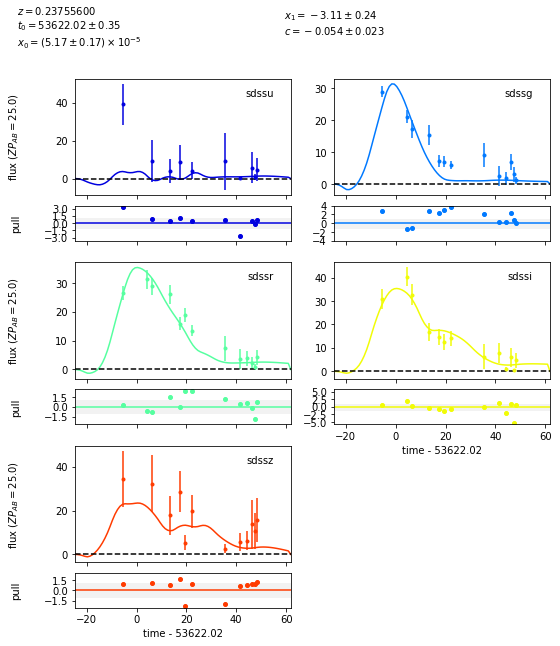

       errors: OrderedDict([('t0', 0.3464980875905894), ('x0', 1.6938335050298902e-06), ('x1', 0.235648839714072), ('c', 0.022862821331641008)])
   parameters: array([ 2.37556000e-01,  5.36220194e+04,  5.17355382e-05, -3.11292989e+00,
       -5.44720214e-02])
      success: True
    chi2_norm: 2.837565383800231
    data_mask: array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])
         ndof: 57
   covariance: array([[ 1.20061899e-01, -2.41431191e-08,  1.43167686e-03,
        -7.46564725e-04],
       [-2.41431191e-08,  2.86907194e-12, -1.71601612e-07,
        -6.6759208

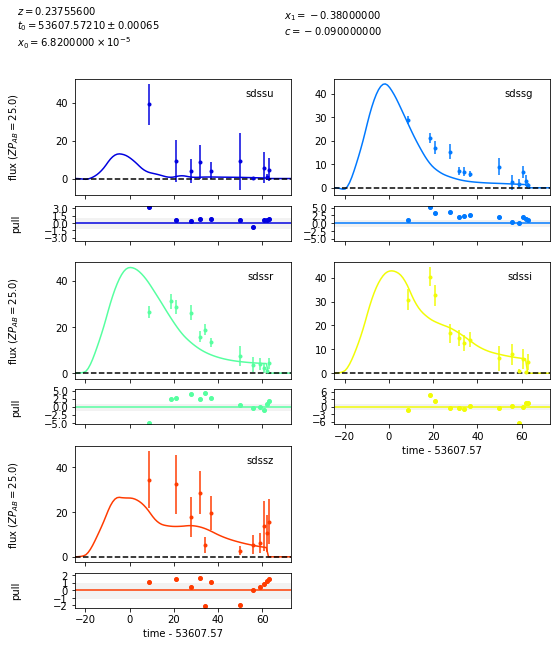

       errors: OrderedDict([('t0', 0.0006475497102655936)])
   parameters: array([ 2.37556000e-01,  5.36075721e+04,  6.82000000e-05, -3.80000000e-01,
       -9.00000000e-02])
      success: True
    chi2_norm: 4.598415324167207
    data_mask: array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])
         ndof: 60
   covariance: array([[4.19320629e-07]])
 vparam_names: ['t0']
        chisq: 275.9049194500324
         nfit: 1
  param_names: ['z', 't0', 'x0', 'x1', 'c']
      message: 'Minimization exited successfully.'
        ncall: 126






In [11]:
print('\n\nFitting for all terms except z:')
source = sncosmo.get_source('salt2', version='2.0')
model = sncosmo.Model(source=source)
model.set(z=input_table.meta['redshift'])

result, fitted_model = sncosmo.fit_lc(input_table, model, ['t0', 'x0', 'x1', 'c'], bounds=None)
result['chi2_norm'] = (result.chisq / result.ndof)
sncosmo.plot_lc(input_table, model=fitted_model, errors=result.errors)
plt.show()
print(result)

print('\n\nFitting with fixed, published values:')
model.set(z=input_table.meta['redshift'], x0=x0, x1=x1, c=c)
result, fitted_model = sncosmo.fit_lc(input_table, model, ['t0'], bounds=None)
result['chi2_norm'] = (result.chisq / result.ndof)
sncosmo.plot_lc(input_table, model=fitted_model, errors=result.errors)
plt.show()
print(result)
print('\n\n\n')
